## Capstone

In [14]:
import pandas as pd
import numpy as np

df = pd.read_csv('Campaign Performance.csv')

### Data Cleaning and Manipulation


In [15]:
df.drop(columns = ['Conversions','Value conv./click','Value conv./coste','Cost/conv.', 'Status','Bid strategy'], inplace = True)

In [3]:
df = pd.get_dummies(df, columns = ['Status', 'Bid strategy'])

In [134]:
df.columns

Index(['Hour of day', 'Budget', 'CPC avg.', 'Impressions', 'Clicks', 'CTR',
       'Cost', 'Conversion rate', 'Percentage viewable',
       'Non viewable impressions distrib.', 'Avg cost', 'Campaign id',
       'Impr. viewable', 'CTR viewable', 'Impr. non viewable',
       'Non measurable impr.', 'CPM avg viewable'],
      dtype='object')

In [18]:
# Labels are the values we want to predict
labels = np.array(df['Conversion rate'])
# Remove the labels from the features
# axis 1 refers to the columns
features= df.drop('Conversion rate', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

In [19]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [20]:
from sklearn.ensemble import RandomForestRegressor

In [21]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (621, 16)
Training Labels Shape: (621,)
Testing Features Shape: (208, 16)
Testing Labels Shape: (208,)


### Initial Model 1: RF with 1000 Decision Trees

In [123]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels)
base_predictions = rf.predict(test_features)
rf_prediction = pd.DataFrame({'Labels':test_labels})
rf_prediction['base_model'] = base_predictions
print(rf_prediction)

     Labels  base_model
0      2.17     2.07612
1      0.85     1.83206
2      3.04     3.10956
3      0.75     1.75340
4      1.82     3.50574
5      0.00     1.76464
6      1.62     2.04285
7      4.27     3.53743
8      2.48     2.41939
9      1.36     1.37222
10     2.07     2.09623
11     1.90     2.19088
12     6.04     6.15535
13     1.67     1.87635
14     4.37     4.17348
15     2.00     1.90596
16     2.26     2.14170
17     2.39     2.43178
18     4.09     3.58908
19     6.49     6.25600
20     3.37     4.11932
21     1.73     2.88761
22     0.00     0.17421
23     0.00     3.26099
24     1.44     1.97717
25     2.11     2.08474
26     0.00     1.24953
27     1.63     1.77717
28     0.00     2.90814
29     1.49     1.63491
..      ...         ...
178    1.93     1.80883
179    5.77     6.24527
180    1.75     2.02665
181    5.71     0.10640
182    0.00     0.38265
183    0.00     3.40964
184    3.14     2.53908
185    0.00     3.60442
186    1.09     2.34083
187    1.72     

In [26]:
test_features[2]

array([1.80000000e+01, 3.00000000e+01, 1.80000000e-01, 1.21436000e+05,
       1.94300000e+03, 1.60000000e+00, 3.49550000e+02, 8.93800000e+01,
       7.99000000e+00, 1.80000000e-01, 7.58102625e+08, 8.17310000e+04,
       1.59000000e+00, 9.70700000e+03, 2.99980000e+04, 2.40000000e+00])

### Model 2: RF + RandomizedSearchCV

In [70]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [71]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 10, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_features, train_labels)
random_predictions = rf_random.predict(test_features)
rf_prediction['rf_random'] = random_predictions

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 14.4min finished


In [196]:
rf_random.best_params_

{'n_estimators': 1800,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': True}

### Model 3: RF with GridSearchCV

In [124]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5, 6],
    'min_samples_split': [2, 4, 6, 8],
    'n_estimators': [1500, 1600, 1700, 1800, 1900, 2000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)
grid_search.fit(train_features, train_labels)
gs_predictions = grid_search.predict(test_features)
rf_prediction['grid_search'] = gs_predictions

Fitting 5 folds for each of 768 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 27.5min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 35.1min
[Parallel(n_jobs=-1)]: Done 3840 out of 3840 | elapsed: 41.3min finished


### Model 4: OLS

In [132]:
## Without a constant
import statsmodels.api as sm
# Note the difference in argument order
OLS_model = sm.OLS(train_labels, train_features).fit()
OLS_predictions = OLS_model.predict(test_features) # make the predictions by the model
rf_prediction['OLS'] = OLS_predictions
# Print out the statistics
OLS_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     123.8
Date:                Mon, 09 Dec 2019   Prob (F-statistic):          2.55e-167
Time:                        16:17:19   Log-Likelihood:                -1193.5
No. Observations:                 621   AIC:                             2415.
Df Residuals:                     607   BIC:                             2477.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0189      0.014      1.370      0.171      -0.008       0.046
x2            -0.0006      0.001     -0.959      0.338      -0.002       0.001
x3             5.8963      0.861      6.847      0.000       4.205       7.587
x4         -6.829e-08   9.27e-07     -0.074      0.941   -1.89e-06    1.75e-06
x5         -1.322e-05   9.69e-05     -0.136      0.892      -0.000       0.000
x6             0.7185      0.276      2.599      0.010       0.175       1.262
x7             0.0012      0.001      2.339      0.020       0.000       0.002
x8             0.0016      0.005      0.306      0.760      -0.009       0.012
x9             0.0063      0.010      0.644      0.520      -0.013       0.026
x10            5.8963      0.861      6.847      0.000       4.205       7.587
x11        -5.584e-10      3e-10     -1.863      0.063   -1.15e-09    3.03e-11
x12         -5.05e-07   1.24e-06     -0.406      0.685   -2.95e-06    1.94e-06
x13           -0.4760      0.234     -2.037      0.042      -0.935      -0.017
x14         2.476e-06   2.93e-06      0.845      0.399   -3.28e-06    8.23e-06
x15        -2.039e-06      2e-06     -1.019      0.309   -5.97e-06    1.89e-06
x16            0.1428      0.098      1.462      0.144      -0.049       0.334
==============================================================================
Omnibus:                      474.205   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17847.804
Skew:                           2.966   Prob(JB):                         0.00
Kurtosis:                      28.585   Cond. No.                     1.60e+21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.19e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Model 5: Linear Regression 

In [131]:
from sklearn import linear_model
lr = linear_model.LinearRegression()
lr_model = lr.fit(train_features,train_labels)
lr_predictions = lr_model.predict(test_features)
rf_prediction['LR'] = lr_predictions
lr_model.score(train_features,train_labels)
print(rf_prediction)

     Labels  base_model  grid_search     lasso   elastic     ridge        LR
0      2.17     2.07612     2.088188  2.153905  2.153905  1.882444  1.880456
1      0.85     1.83206     1.680416  2.142516  2.142516  1.774538  1.770883
2      3.04     3.10956     3.326763  3.305514  3.305514  3.303519  3.303269
3      0.75     1.75340     1.850339  2.015794  2.015794  1.946031  1.945653
4      1.82     3.50574     3.674091  1.881847  1.881847  1.824015  1.823957
5      0.00     1.76464     2.618786  3.074462  3.074462  3.216668  3.217908
6      1.62     2.04285     1.951159  2.246691  2.246691  2.068636  2.066938
7      4.27     3.53743     3.621087  3.089900  3.089900  3.740025  3.745594
8      2.48     2.41939     2.930347  3.144073  3.144073  3.138380  3.138558
9      1.36     1.37222     1.356678  1.942305  1.942305  1.844773  1.844288
10     2.07     2.09623     1.963233  2.152872  2.152872  1.991998  1.990821
11     1.90     2.19088     2.048951  2.412902  2.412902  2.423278  2.422992

In [80]:
lr_model.score(train_features,train_labels)

0.32888111426580213

### Model 5: Ridge Regression

In [130]:
from sklearn.linear_model import Ridge

lr_ridge = Ridge(alpha = 0.01).fit(train_features, train_labels)
lr_ridge.score(train_features, train_labels)
ridge_predictions = lr_ridge.predict(test_features)
rf_prediction['ridge'] = ridge_predictions

print(rf_prediction)

     Labels  base_model  grid_search     lasso   elastic     ridge
0      2.17     2.07612     2.088188  2.153905  2.153905  1.882444
1      0.85     1.83206     1.680416  2.142516  2.142516  1.774538
2      3.04     3.10956     3.326763  3.305514  3.305514  3.303519
3      0.75     1.75340     1.850339  2.015794  2.015794  1.946031
4      1.82     3.50574     3.674091  1.881847  1.881847  1.824015
5      0.00     1.76464     2.618786  3.074462  3.074462  3.216668
6      1.62     2.04285     1.951159  2.246691  2.246691  2.068636
7      4.27     3.53743     3.621087  3.089900  3.089900  3.740025
8      2.48     2.41939     2.930347  3.144073  3.144073  3.138380
9      1.36     1.37222     1.356678  1.942305  1.942305  1.844773
10     2.07     2.09623     1.963233  2.152872  2.152872  1.991998
11     1.90     2.19088     2.048951  2.412902  2.412902  2.423278
12     6.04     6.15535     5.462329  3.984552  3.984552  3.851450
13     1.67     1.87635     1.994485  1.996639  1.996639  1.99

C:\Users\pltru\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.105687e-22
  overwrite_a=True).T


### Model 6: Lasso Regression

In [128]:
from sklearn.linear_model import Lasso

lr_lasso = Lasso(alpha = 0.01).fit(train_features, train_labels)
lr_lasso.score(train_features, train_labels)
lasso_predictions = lr_lasso.predict(test_features)
rf_prediction['lasso'] = lasso_predictions

print(rf_prediction)

     Labels  base_model  grid_search     lasso
0      2.17     2.07612     2.088188  2.153905
1      0.85     1.83206     1.680416  2.142516
2      3.04     3.10956     3.326763  3.305514
3      0.75     1.75340     1.850339  2.015794
4      1.82     3.50574     3.674091  1.881847
5      0.00     1.76464     2.618786  3.074462
6      1.62     2.04285     1.951159  2.246691
7      4.27     3.53743     3.621087  3.089900
8      2.48     2.41939     2.930347  3.144073
9      1.36     1.37222     1.356678  1.942305
10     2.07     2.09623     1.963233  2.152872
11     1.90     2.19088     2.048951  2.412902
12     6.04     6.15535     5.462329  3.984552
13     1.67     1.87635     1.994485  1.996639
14     4.37     4.17348     4.058531  3.112853
15     2.00     1.90596     2.008235  2.253123
16     2.26     2.14170     2.116230  2.068910
17     2.39     2.43178     2.898472  3.109782
18     4.09     3.58908     3.432229  2.483774
19     6.49     6.25600     5.506936  4.647962
20     3.37  

C:\Users\pltru\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


### Model 7: Multitask Elastic Net

In [129]:
from sklearn.linear_model import ElasticNet
elastic = ElasticNet(alpha=0.01, l1_ratio = 1).fit(train_features, train_labels)
elastic.score(train_features, train_labels)
elastic_predictions = elastic.predict(test_features)
rf_prediction['elastic'] = elastic_predictions

print(rf_prediction)

     Labels  base_model  grid_search     lasso   elastic
0      2.17     2.07612     2.088188  2.153905  2.153905
1      0.85     1.83206     1.680416  2.142516  2.142516
2      3.04     3.10956     3.326763  3.305514  3.305514
3      0.75     1.75340     1.850339  2.015794  2.015794
4      1.82     3.50574     3.674091  1.881847  1.881847
5      0.00     1.76464     2.618786  3.074462  3.074462
6      1.62     2.04285     1.951159  2.246691  2.246691
7      4.27     3.53743     3.621087  3.089900  3.089900
8      2.48     2.41939     2.930347  3.144073  3.144073
9      1.36     1.37222     1.356678  1.942305  1.942305
10     2.07     2.09623     1.963233  2.152872  2.152872
11     1.90     2.19088     2.048951  2.412902  2.412902
12     6.04     6.15535     5.462329  3.984552  3.984552
13     1.67     1.87635     1.994485  1.996639  1.996639
14     4.37     4.17348     4.058531  3.112853  3.112853
15     2.00     1.90596     2.008235  2.253123  2.253123
16     2.26     2.14170     2.1

C:\Users\pltru\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


## Export to CSV

In [133]:
rf_prediction.to_csv('predictions.csv', index = False)

In [193]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(train_features, train_labels)
base_model.predict(test_features)
test = pd.DataFrame({'Labels':test_labels})
test['predictions'] = predictions
test.to_csv('results_6.csv', index = False)

array([2.151, 1.68 , 3.125, 1.667, 2.97 , 1.802, 2.111, 3.51 , 2.176,
       1.359, 2.004, 2.275, 6.434, 1.692, 4.539, 1.695, 2.269, 2.247,
       2.837, 6.213, 4.041, 2.696, 0.   , 3.436, 2.029, 2.153, 0.981,
       1.72 , 0.714, 1.578, 3.618, 1.56 , 0.95 , 3.164, 2.214, 0.975,
       1.445, 4.299, 4.295, 1.554, 1.9  , 0.848, 1.687, 3.507, 3.755,
       1.109, 2.108, 2.102, 1.677, 1.346, 0.624, 3.341, 1.851, 1.429,
       1.375, 2.023, 0.959, 2.344, 5.88 , 4.061, 2.094, 0.405, 5.061,
       3.041, 3.601, 3.311, 0.826, 2.072, 3.857, 5.14 , 1.684, 1.835,
       1.73 , 2.372, 1.963, 2.428, 7.227, 3.967, 2.164, 1.564, 0.687,
       0.911, 0.   , 1.239, 2.132, 1.368, 1.654, 3.601, 2.338, 4.586,
       1.197, 2.856, 1.677, 1.748, 2.506, 2.615, 3.92 , 1.095, 3.372,
       2.27 , 2.529, 0.838, 1.76 , 1.601, 7.013, 5.935, 1.934, 1.363,
       1.42 , 1.582, 3.22 , 2.391, 0.837, 0.473, 3.552, 1.906, 3.289,
       2.247, 2.539, 1.16 , 1.348, 1.716, 1.57 , 2.191, 0.   , 2.74 ,
       5.945, 2.376,

In [45]:
# Get numerical feature importances
importances = list(rf_random.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: Avg cost             Importance: 0.16
Variable: CPC avg.             Importance: 0.15
Variable: Non measurable impr. Importance: 0.15
Variable: Cost                 Importance: 0.08
Variable: Clicks               Importance: 0.06
Variable: CTR                  Importance: 0.06
Variable: Impr. viewable       Importance: 0.05
Variable: CPM avg viewable     Importance: 0.05
Variable: Impressions          Importance: 0.04
Variable: Percentage viewable  Importance: 0.04
Variable: CTR viewable         Importance: 0.04
Variable: Campaign id          Importance: 0.03
Variable: Impr. non viewable   Importance: 0.03
Variable: Hour of day          Importance: 0.02
Variable: Budget               Importance: 0.02
Variable: Non viewable impressions distrib. Importance: 0.02


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

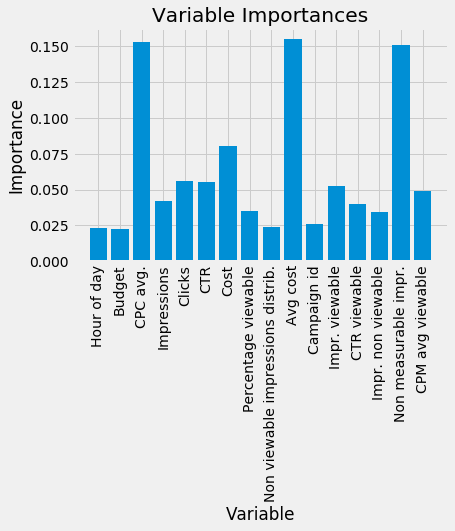

In [46]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [203]:
print('Mean Absolute Error:', round(np.mean(errors), 2), 'percent')

Mean Absolute Error: 0.95 percent


In [61]:
!pip install pydot

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


## User Interface

In [126]:
def getprediction():

    # Calls for an infinite loop that keeps executing
    # until an exception occurs
    while True:
        campaign_id = int(input("What's the Campaign id? "))
        budget = int(input("What's the budget? "))             
        hour = int(input("What hour of the day? "))
        impressions = int(input("Number of Impressions Estimated or Actual? "))
        impressions_viewable = int(input("Impressions viewable? "))
        impressions_non_viewable = int(input("Impressions non-viewable? "))
        impressions_non_measurable = impressions - (impressions_viewable + impressions_non_viewable)
        clicks = int(input("Number of Clicks Estimated or Actual? "))
        ctr = clicks/impressions
        cost = int(input("Cost Estimated or Actual? "))
        cpc_avg = cost / clicks
        avg_cost = cost / clicks
        percentage_viewable = float(input("Percentage viewable (%)? "))
        ctr_viewable = float(input("CTR viewable? "))
        CPM_avg_viewable = float(input("CPM average viewable? "))
        non_viewable_impressions_distrib = input("Non-viewable impressions distribution (if known)? ")
        list = [campaign_id, budget, hour, impressions, impressions_viewable, impressions_non_viewable, 
            impressions_non_measurable, clicks, ctr, cost, cpc_avg, avg_cost, percentage_viewable, ctr_viewable, CPM_avg_viewable,
           CPM_avg_viewable]
        test_features = []
        for item in list: # comma, or other
            test_features.append(item)
        test_features = np.array(test_features).reshape(1,-1)
        prediction = grid_search.predict(test_features)
        print("The predicted conversion rate at", hour, "hour for Campaign ID", campaign_id, "is:",round(prediction[0],2), "%")
        break

Key Takeaways:

With the current chosen model, the predictions for conversion rates are accurate for campaigns that are ran with conversion rates. However, the model is currently not predicting well the campaigns that have 0 conversion rates. For future reference, our group conclude that there should be more data collected in daily cadence. Hour of the day is a good metric, but it is a better metric if the company can scrape daily/hour cadence data. With this, we can see the seasonal breakdown as well as trends that might exist in the data. Time-series forecasting methods can even be used for campaigns in order for the business to take an outlook about the current campaigns that are ongoing. 

MAE refers to Mean Absolute Error, which is
$$ \frac{1}{n} \sum1^n |yi - \hat{y}_i| $$
This gives less weight to outliers, which is not sensitive to outliers.

MAPE refers to Mean Absolute Percentage Error, which is
$$\frac{100}{n} \sumi^n \frac{yi - \hat{y}i}{yi} $$
Similar to MAE, but normalized by true observation. Downside is when true obs is zero, this metric will be problematic.

MSE refers to Mean Squared Error, which is
$$\frac{1}{n} \sumi^n (yi - \hat{y}_i)^2$$
MSE is like a combination measurement of bias and variance of your prediction, i.e., MSE = Bias^2 + Variance, which is also most popular one I guess.

RMSE refers to Root MSE, usually take a root of MSE would bring the unit back to actual unit, easy to interpret your model accuracy.

NRMSE refers to the normalized RMSE numbers which is easier when comparing numbers from different models

In [136]:
getprediction()

What's the Campaign id? 1356947003
What's the budget? 200
What hour of the day? 6
Number of Impressions Estimated or Actual? 10000
Impressions viewable? 2000
Impressions non-viewable? 5000
Number of Clicks Estimated or Actual? 200
Cost Estimated or Actual? 500
Percentage viewable (%)? 80
CTR viewable? 2
CPM average viewable? 1
Non-viewable impressions distribution (if known)? 0
The predicted conversion rate at 6 hour for Campaign ID 1356947003 is: 4.03 %


In [ ]:
1356947003